In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [3]:
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C


In [4]:
label_encoder = LabelEncoder()
for col in ['Name', 'Sex', 'Ticket']:
    train_data[col] = label_encoder.fit_transform(train_data[col])
    test_data[col] = label_encoder.fit_transform(test_data[col])

In [5]:
train_data.fillna(train_data.select_dtypes(include=[np.number]).mean(), inplace=True)
test_data.fillna(test_data.select_dtypes(include=[np.number]).mean(), inplace=True)


In [6]:
train_df = train_data.drop(['PassengerId', 'Survived', 'Age', 'Cabin', 'Embarked'], axis=1)
target_df = train_data['Survived']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, test_size=0.2, random_state=42)


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
train_input = torch.tensor(X_train_scaled, dtype=torch.float32)
train_label = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
test_input = torch.tensor(X_test_scaled, dtype=torch.float32)
test_label = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [10]:
assert not torch.isnan(train_input).any(), "NaNs found in train_input"
assert not torch.isnan(train_label).any(), "NaNs found in train_label"
assert not torch.isnan(test_input).any(), "NaNs found in test_input"
assert not torch.isnan(test_label).any(), "NaNs found in test_label"
assert not torch.isinf(train_input).any(), "Infinities found in train_input"
assert not torch.isinf(train_label).any(), "Infinities found in train_label"
assert not torch.isinf(test_input).any(), "Infinities found in test_input"
assert not torch.isinf(test_label).any(), "Infinities found in test_label"


In [11]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

In [12]:
from kan import KAN, create_dataset

input_dim = train_input.shape[1]  # Number of input features
output_dim = 1  # Binary classification (Survived)
model = KAN(width=[input_dim, 5, output_dim], grid=3, k=2, seed=0)  # Simplified model configuration

In [13]:
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)


train loss: 3.72e-01 | test loss: 3.94e-01 | reg: 1.07e+01 : 100%|██| 20/20 [00:06<00:00,  3.17it/s]


{'train_loss': [array(0.4602418, dtype=float32),
  array(0.4598353, dtype=float32),
  array(0.4552617, dtype=float32),
  array(0.3890247, dtype=float32),
  array(0.38870126, dtype=float32),
  array(0.38181958, dtype=float32),
  array(0.37791392, dtype=float32),
  array(0.37768677, dtype=float32),
  array(0.37822595, dtype=float32),
  array(0.3756891, dtype=float32),
  array(0.3788453, dtype=float32),
  array(0.3793897, dtype=float32),
  array(0.3833596, dtype=float32),
  array(0.38062876, dtype=float32),
  array(0.37658766, dtype=float32),
  array(0.3743297, dtype=float32),
  array(0.37464774, dtype=float32),
  array(0.37261733, dtype=float32),
  array(0.3723365, dtype=float32),
  array(0.3721374, dtype=float32)],
 'test_loss': [array(0.4708136, dtype=float32),
  array(0.47298735, dtype=float32),
  array(0.46221903, dtype=float32),
  array(0.3930871, dtype=float32),
  array(0.39905027, dtype=float32),
  array(0.39053425, dtype=float32),
  array(0.38853738, dtype=float32),
  array(0.390

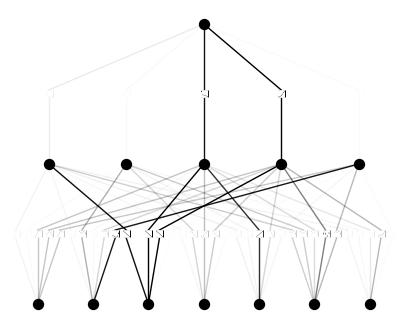

In [14]:
model(dataset['train_input'])
model.plot(beta=100)

train loss: 3.71e-01 | test loss: 3.88e-01 | reg: 9.09e+00 : 100%|██| 50/50 [00:01<00:00, 47.40it/s]


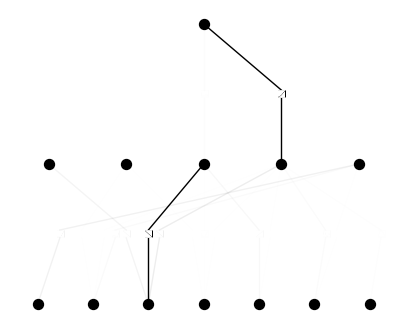

In [15]:
model.train(dataset, opt="Adam", steps=50, lr=0.001, lamb=0.01, lamb_entropy=10.)
model.plot()

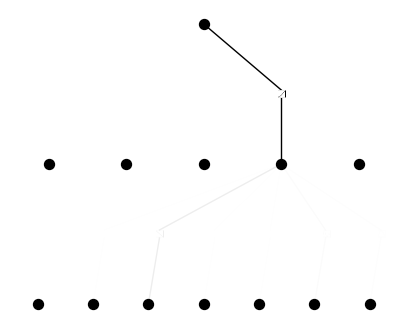

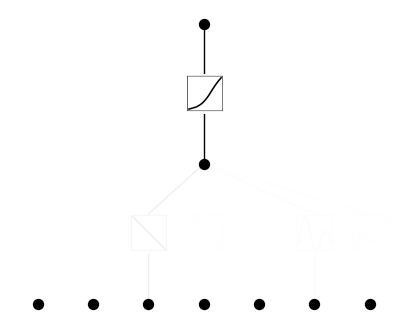

In [16]:
model.prune()
model.plot(mask=True)
model = model.prune()
model(dataset['train_input'])
model.plot()

train loss: 3.70e-01 | test loss: 3.85e-01 | reg: 6.11e+00 : 100%|█| 50/50 [00:00<00:00, 106.79it/s]


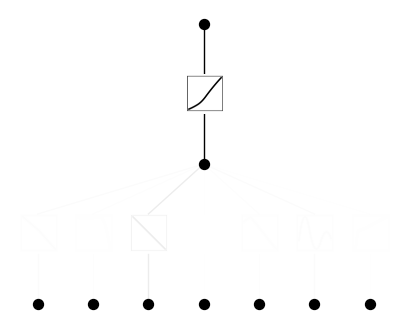

In [17]:
model.train(dataset, opt="Adam", steps=50, lr=0.001)
model.plot()

In [18]:
mode = "auto"  # Use automatic mode for setting symbolic functions
if mode == "manual":
    model.fix_symbolic(0,0,0,'sin')
    model.fix_symbolic(0,1,0,'x^2')
    model.fix_symbolic(1,0,0,'sgn')
elif mode == "auto":
    lib = ["tanh",
"sigmoid",
"gaussian",
"arctan",
"sin",
"x^2",
"cosh",
"x^3",
"x^4",
"exp",
"1/x^4",
"1/x^3",
"1/x^2",
"1/x",
"tan",
"1/sqrt(x)",
"log",
"arctanh",
"sqrt",
"arcsin",
"abs",
"x",
"sgn",]
    model.auto_symbolic(lib=lib)
    # model.fix_symbolic(1,0,0,'sigmoid') # fix the last layer

fixing (0,0,0) with x^3, r2=1.0000007152557373
fixing (0,1,0) with gaussian, r2=0.9895971417427063
fixing (0,2,0) with x^2, r2=1.0000009536743164
fixing (0,3,0) with sin, r2=0.9994357824325562
fixing (0,4,0) with abs, r2=0.9996124505996704
fixing (0,5,0) with sin, r2=0.7469987273216248
fixing (0,6,0) with arctan, r2=0.9739071726799011
fixing (1,0,0) with tanh, r2=0.9997720718383789


In [19]:
model.train(dataset, opt="Adam", steps=100, lr=0.001)
symbolic_formula = model.symbolic_formula()[0][0]
print(symbolic_formula)

train loss: 3.96e-01 | test loss: 4.27e-01 | reg: 2.74e+00 : 100%|█| 100/100 [00:00<00:00, 108.60it/


0.67*tanh(0.33*(-0.12*x_1 - 1)**3 - 3.15*(-0.45*x_3 - 1)**2 + 0.43*sin(8.04*x_4 - 0.99) + 0.3*sin(2.18*x_6 - 8.59) - 0.03*Abs(7.25*x_5 - 3.82) + 0.23*atan(5.15*x_7 + 2.03) + 0.59 - 0.28*exp(-11.0*(1 - 0.53*x_2)**2)) + 0.74


In [20]:
y_pred_sub = model(test_input).detach().numpy()

In [21]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true=test_label, y_score=y_pred_sub.flatten()))

0.8639639639639639


<AxesSubplot: >

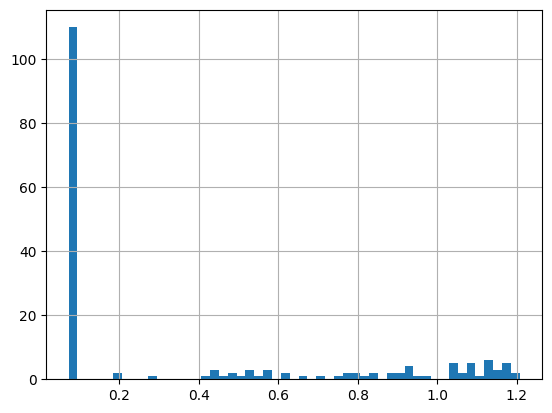

In [22]:
pd.Series(y_pred_sub.flatten()).hist(bins=51)

# 
- The model had some cpu error when I tried to do it with 3 or 7 nodes in the hidden layer.
- When I ran the nb with 5 nodes, I got different performance. So it was not very reproducible. I am not sure if there is some other seed that I need to fix to make it reproducible.
- Tried with just one node in the middle layer to simulate a Logistic regressor. But the last layer did not look like a sigmoid. When I fixed it to a sigmoid, got slightly worse performance.
- Ran the model again with 5 nodes in the middle layer, got different model and different occasions.